## Connect to MariaDB Platform

In [1]:
import mariadb
import sys
import configparser
config  = configparser.ConfigParser()
config.read('config.ini')

try:
    conn = mariadb.connect(
        user=config["setting"]["user"],
        password=config["setting"]["password"],
        host=config["setting"]["host"],
        port=int(config["setting"]["port"]),
        database=config["setting"]["database"]

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

## Prepare SQL query cmd

In [2]:
import datetime
sensor_code = "6f01be05" # main_farm: 6f01be05  # CO2 exp: a1578703
features = ["entity_id", "state", "last_updated"]
base_cmd = f'select {", ".join(features)} from states where'
data_types = ["carbon_dioxide_concentration", "humidity", "temperature"]

t_begin_unix = 1649674801
t_end_unix =   1650279601

t_begin = str(datetime.datetime.fromtimestamp(t_begin_unix).strftime('%Y-%m-%d %H:%M:%S'))
t_end = str(datetime.datetime.fromtimestamp(t_end_unix).strftime('%Y-%m-%d %H:%M:%S'))
print("Begin: ",t_begin)
print("End: ",t_end)

Begin:  2022-04-11 13:00:01
End:  2022-04-18 13:00:01


## Combine the proper SQL query

In [3]:
entity_cmd_list = []
for data_type in data_types:
    entity_cmd_list.append(f'entity_id like "%{sensor_code}_{data_type}%"')
entity_cmd = "(" +  ' or '.join(entity_cmd_list) + ")"
full_cmd = f"{base_cmd} {entity_cmd} and last_updated <='{t_end}' and last_updated >='{t_begin}'" 
print(full_cmd)
cur.execute(full_cmd)
vals = [_ for _ in cur]

select entity_id, state, last_updated from states where (entity_id like "%6f01be05_carbon_dioxide_concentration%" or entity_id like "%6f01be05_humidity%" or entity_id like "%6f01be05_temperature%") and last_updated <='2022-04-18 13:00:01' and last_updated >='2022-04-11 13:00:01'


## Convert query to dataframe

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import zscore

df_home = pd.DataFrame.from_records(vals, columns=features)
df_home["time_s"] = df_home["last_updated"].apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) 

## Load atlatics data

In [5]:
df_at = pd.read_csv("feeds-main-farm.csv", names=["time", "id", "ph", "EC", "water_T", "lat", "longi", "elevation", "status"])
df_at = df_at.drop(["id","lat","longi","elevation","status"], axis=1) # delete redundant columns
df_at = df_at.drop([0], axis=0) # delete the name filed
df_at["time_s"] = df_at.time.apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) # convert to unix time step
df_at[["ph", "EC", "water_T"]] = df_at[["ph", "EC", "water_T"]].apply(pd.to_numeric) # conver to numeric value

/home/hexaburbach/anaconda3/envs/analysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_home[df_home.state=="unavailable"] # should deal with unavailable data type.

,entity_id,state,last_updated,time_s
3416,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078752,1650278179
3417,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078770,1650278179
3418,sensor.titan_products_ltd_tpzrco2ht_z3_6f01be0...,unavailable,2022-04-18 10:36:19.078807,1650278179


In [7]:
df_home["sensor"] = df_home.entity_id.str.split('_').str[-1]
df_home["state"] = df_home["state"].replace({'unavailable':np.nan})
df_home.state = df_home.state.astype(np.float16)

## Create columns for features

In [8]:
df_home = pd.get_dummies(df_home, columns=['sensor'])
df_home = df_home.rename(columns={'sensor_concentration':'CO2', 'sensor_humidity':'humidity','sensor_temperature':'air_T'})
df_home.CO2 = df_home.CO2 * df_home.state
df_home.humidity = df_home.humidity * df_home.state
df_home.air_T = df_home.air_T * df_home.state

## Filter data frames

In [9]:
df_home[["CO2", "humidity", "air_T"]] = df_home[["CO2", "humidity", "air_T"]].replace({'0':np.nan, 0:np.nan})
df_at_fit = df_at[(df_at.time_s>t_begin_unix)  & (df_at.time_s<t_end_unix)]

## Load area files

In [10]:
GROW_FILE = 'hexa_volume6.csv'
df_grow = pd.read_csv(GROW_FILE)
df_grow['time_s'] = df_grow['file_name'].apply(lambda x: x.split('-')[-1].split('.')[0]).astype(np.int64)
df_grow = df_grow.drop("file_name", axis=1)

## Merge different data frames

In [45]:
from functools import reduce
df_merge = reduce(lambda left, right: pd.merge(left, right, how="outer", on="time_s"), [df_home, df_at_fit, df_grow])
df_merge = df_merge.drop(["entity_id", "state", "last_updated", "time"], axis=1)
df_merge.head(10)

,time_s,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
0,1649682040,NaN,33.593750,NaN,NaN,NaN,NaN,NaN,NaN
1,1649682101,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN
2,1649682222,NaN,34.812500,NaN,NaN,NaN,NaN,NaN,NaN
3,1649682312,NaN,35.812500,NaN,10.21,1426.0,18.53,NaN,NaN
4,1649682343,NaN,34.406250,NaN,NaN,NaN,NaN,NaN,NaN
5,1649682373,NaN,33.312500,NaN,NaN,NaN,NaN,NaN,NaN
6,1649682373,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1649682433,NaN,34.906250,NaN,NaN,NaN,NaN,NaN,NaN
8,1649682494,NaN,33.093750,NaN,NaN,NaN,NaN,NaN,NaN
9,1649682524,NaN,31.703125,NaN,NaN,NaN,NaN,NaN,NaN


## Create relative time
This is time starting from the beginning of the batch

In [47]:
df_merge["time_rel_h"] = np.round((df_merge.time_s - df_merge.time_s.min())/3600, 3)
df_merge = df_merge.sort_values(by="time_rel_h")
df_merge = df_merge.drop("time_s", axis=1).set_index("time_rel_h")
df_merge = df_merge.interpolate('index',  limit_direction='both')
df_merge.head(10)

,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
time_rel_h,,,,,,,,
0.000,398.0,33.59375,19.0,9.76,1418.0,18.05,32.00000,17.00000
0.004,398.0,33.59375,19.0,9.76,1418.0,18.05,32.01500,17.03500
0.013,398.0,33.59375,19.0,9.76,1418.0,18.05,32.04875,17.11375
0.022,398.0,33.59375,19.0,9.76,1418.0,18.05,32.08250,17.19250
0.031,398.0,33.59375,19.0,9.76,1420.0,18.05,32.11625,17.27125
0.041,398.0,33.59375,19.0,9.76,1419.0,18.06,32.15375,17.35875
0.049,398.0,33.59375,19.0,9.75,1419.0,18.06,32.18375,17.42875
0.059,398.0,33.59375,19.0,9.75,1421.0,18.05,32.22125,17.51625
0.069,398.0,33.59375,19.0,9.76,1419.0,18.07,32.25875,17.60375


## Plot data
There is outliers in EC

array([[<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>]], dtype=object)

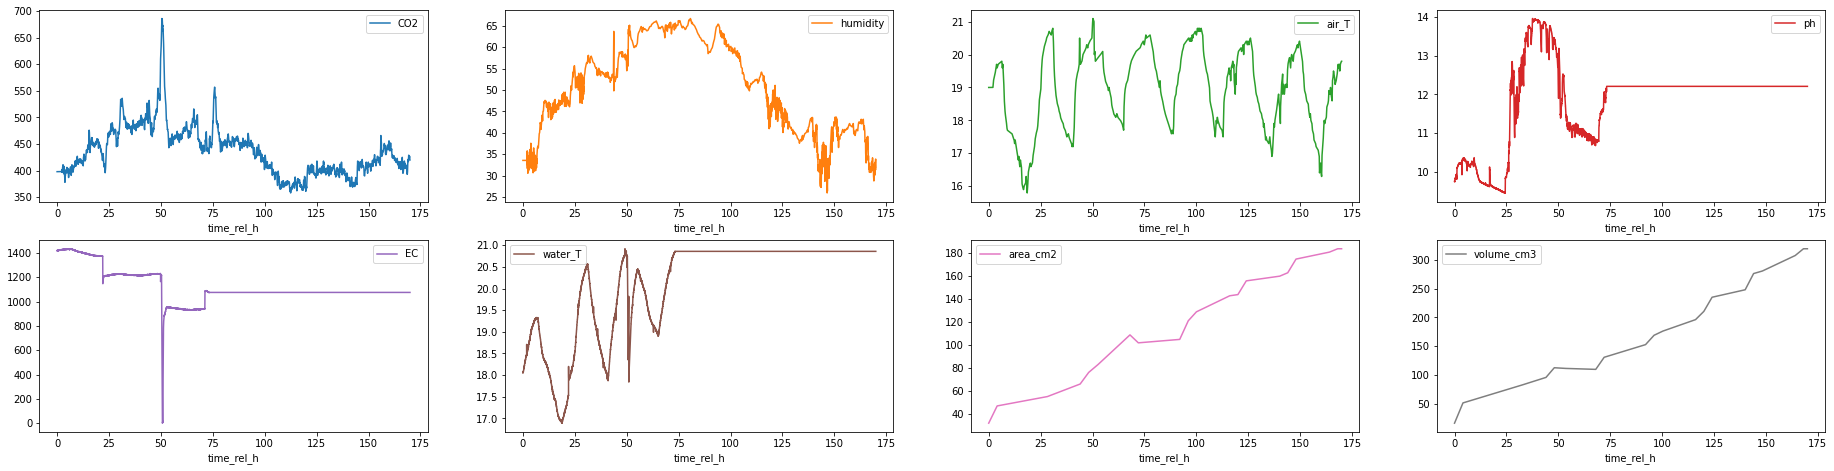

In [48]:
df_merge.plot(figsize=(32, 12), subplots=True, layout=(3,4), sharex=False)

In [49]:
df_merge.describe()

,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
count,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000
mean,455.526922,52.314982,18.831996,11.506468,1169.008425,19.395849,81.804784,110.449869
std,47.376203,10.021085,1.271351,1.355622,189.006300,1.153392,37.057138,61.602462
min,358.000000,26.000000,15.796875,9.460000,0.000000,16.890000,32.000000,17.000000
25%,417.303571,46.047857,17.786076,10.230000,1075.000000,18.500000,52.853333,71.023333
50%,456.750000,53.411020,19.031960,11.430000,1216.000000,19.370000,65.499500,95.181000
75%,482.812500,61.468363,19.923735,12.210000,1373.000000,20.440000,102.501641,112.320063
max,686.000000,66.687500,21.093750,13.960000,1434.000000,20.920000,184.000000,319.000000


## Insight from statistics
- standard deviation of EC and CO2 is pretty high. Need to check outliers
- area and volums are fine because they linearly increase. 
- ph sensor is off. Need to calibrate again.
- air temperature has big temperature difference between min and max.

## Eleminate sensor error (Dealing with outliers)

Outliers are detected in EC: 


time_rel_h
50.646    207.780488
50.654    184.034146
50.671    133.573171
50.705     32.651220
50.716      0.000000
50.721      0.000000
50.725      0.000000
50.733      0.000000
50.738      1.666667
50.742      3.000000
50.747      3.000000
50.750      3.000000
50.759      4.000000
50.763      5.000000
50.767      6.000000
50.776      7.000000
50.784      8.000000
50.793      8.000000
50.801     10.000000
50.806     10.000000
50.810     10.000000
50.814     10.000000
50.819     10.000000
50.827     11.000000
50.831     11.444444
50.836     12.000000
50.844     12.000000
50.852     11.000000
50.856     11.888889
50.861     13.000000
50.870     13.000000
50.872     13.000000
50.878     13.000000
50.887     13.000000
50.889     13.000000
50.895     13.000000
50.904     15.000000
50.912     13.000000
50.921     13.000000
50.929     15.000000
50.938     12.000000
50.947     15.000000
50.955     13.000000
50.964     13.000000
50.972     15.000000
50.973     15.000000
50.981     15.000000
50

After treating outliers in EC: 


time_rel_h
50.646    233.559566
50.654    235.592304
50.671    239.911870
50.705    248.551003
50.716    251.346016
50.721    252.616477
50.725    253.632846
50.733    255.665583
50.738    256.936043
50.742    257.952412
50.747    259.222873
50.750    259.985149
50.759    262.271978
50.763    263.288347
50.767    264.304715
50.776    266.591545
50.784    268.624282
50.793    270.911111
50.801    272.943848
50.806    274.214309
50.810    275.230678
50.814    276.247046
50.819    277.517507
50.827    279.550244
50.831    280.566612
50.836    281.837073
50.844    283.869810
50.852    285.902547
50.856    286.918916
50.861    288.189377
50.870    290.476206
50.872    290.984390
50.878    292.508943
50.887    294.795772
50.889    295.303957
50.895    296.828509
50.904    299.115339
50.912    301.148076
50.921    303.434905
50.929    305.467642
50.938    307.754472
50.947    310.041301
50.955    312.074038
50.964    314.360867
50.972    316.393604
50.973    316.647696
50.981    318.680434
50

array([[<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>]], dtype=object)

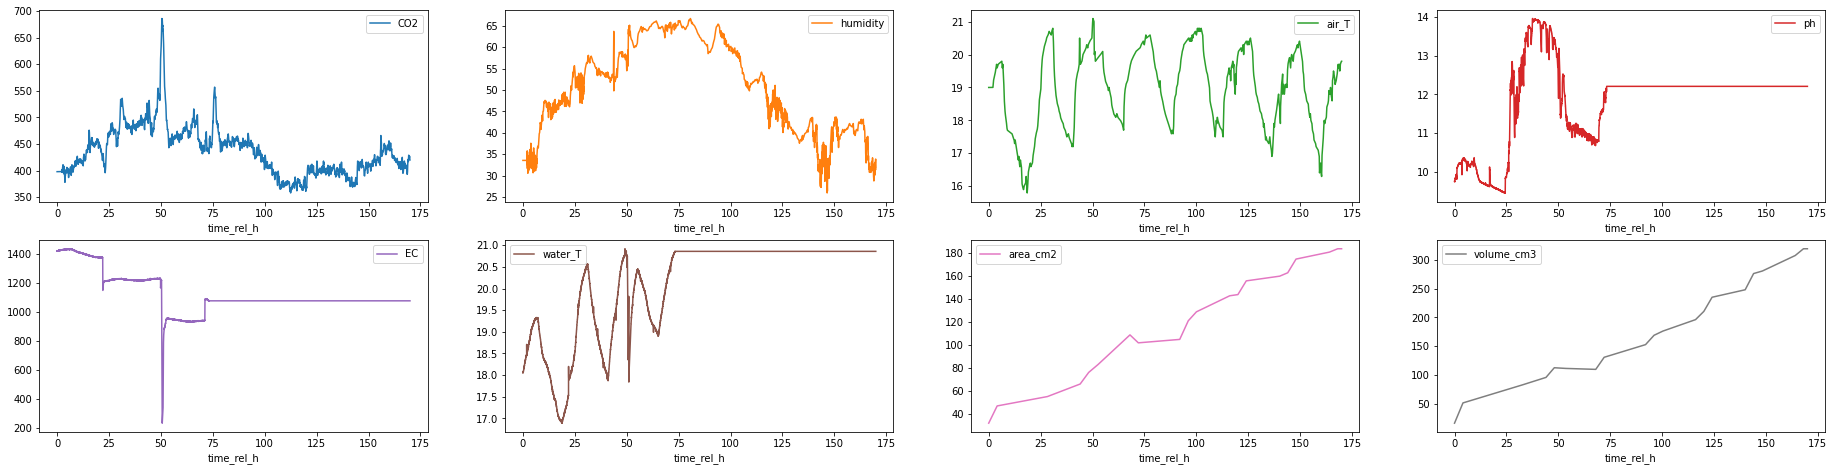

In [50]:
def detect_outlier(df: pd.DataFrame, df_z_score: pd.DataFrame, features: List, thres: int = 5):
    """ Detect outliers using z-score """
    from IPython.display import display
    for feature in features:

        if (abs(df_z_score[feature])>thres).sum():
            print(f"Outliers are detected in {feature}: ")
            display(df[feature][abs(df_z_score[feature])>thres])
            df[feature][abs(df_z_score[feature])>thres] = np.nan
            
            df[feature] = df[feature].interpolate('slinear',  limit_direction='both')
            print(f"After treating outliers in {feature}: ")
            display(df[feature][abs(df_z_score[feature])>thres])
    return df

df_merge_z_score = df_merge.apply(zscore) 
target_features = ["EC", "ph", "CO2"]
df_merge = detect_outlier(df_merge, df_merge_z_score, target_features, thres=5)
df_merge.plot(figsize=(32, 12), subplots=True, layout=(3,4), sharex=False)

## Smooth value to remove outlier or error values.
Be aware not to loose detail. \
Set up K through different experiment

array([[<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>]], dtype=object)

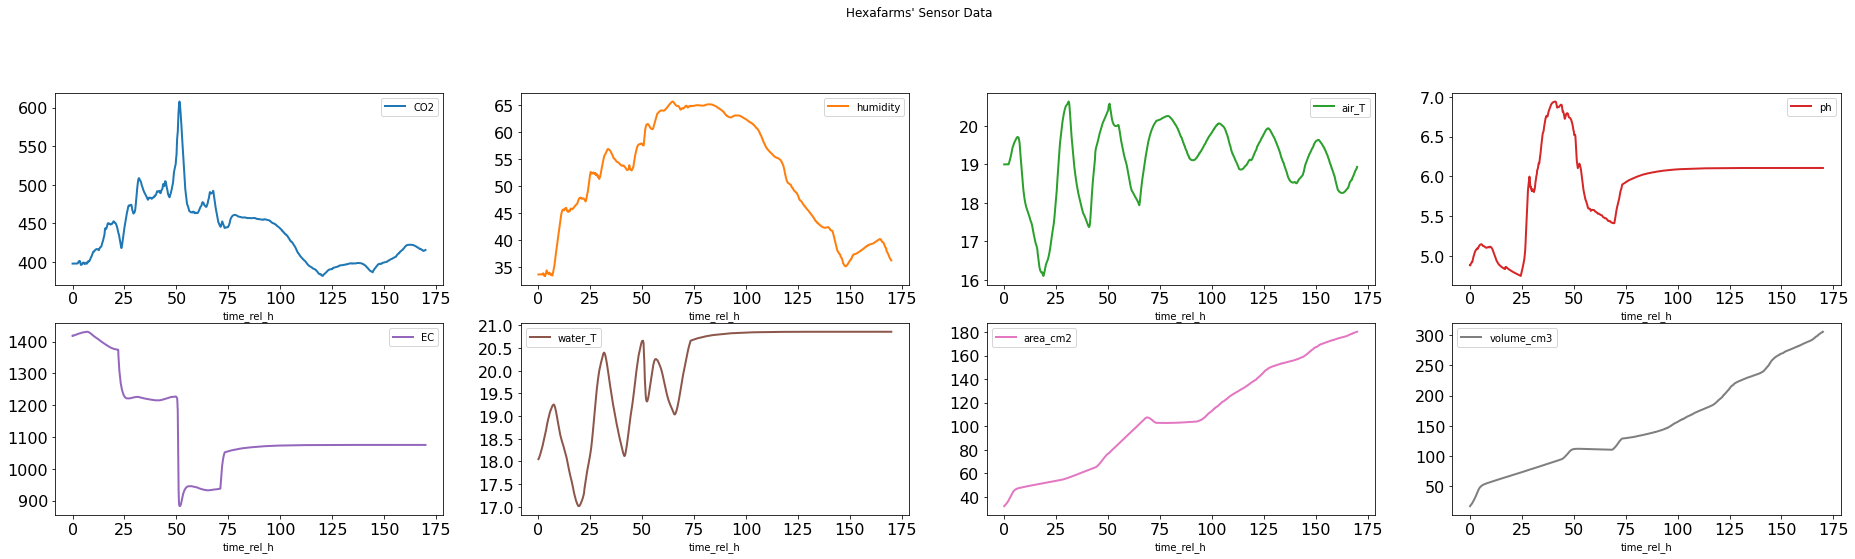

In [56]:
K = 350 # smoothing factor 
df_merge_smooth = df_merge.ewm(span = K).mean()
df_merge_smooth.plot(figsize=(32, 12), title="Hexafarms' Sensor Data", lw=2, fontsize=16,  subplots=True, layout=(3,4), sharex=False)


In [57]:
df_merge_smooth.to_csv("fake_data.csv")

## Normalize values
Since normalized, each value can be plotted together.

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df_merge_scale = pd.DataFrame(scaler.fit_transform(df_merge), columns=df_merge.columns, index=df_merge.index)


<AxesSubplot:xlabel='time_rel_h'>

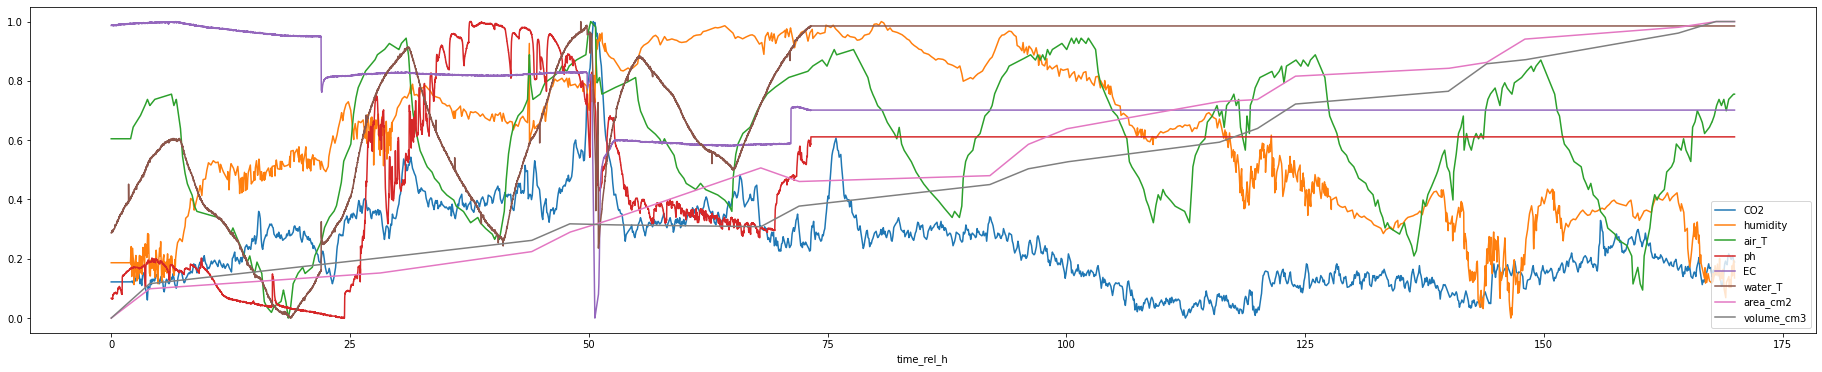

In [53]:
df_merge_scale.plot(figsize=(32, 6))

## Correlation map

In [54]:
corr_merge = df_merge_scale.corr()
mask = np.zeros_like(corr_merge, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_merge[mask] = np.nan
corr_merge.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').format(precision=2, na_rep='NA')

/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
CO2,NA,NA,NA,NA,NA,NA,NA,NA
humidity,0.60,NA,NA,NA,NA,NA,NA,NA
air_T,0.19,0.20,NA,NA,NA,NA,NA,NA
ph,0.40,0.27,0.37,NA,NA,NA,NA,NA
EC,-0.37,-0.67,-0.34,-0.29,NA,NA,NA,NA
water_T,-0.04,0.22,0.72,0.49,-0.51,NA,NA,NA
area_cm2,-0.21,0.08,0.22,0.30,-0.62,0.69,NA,NA
volume_cm3,-0.21,-0.06,0.20,0.37,-0.49,0.67,0.97,NA


## Smooth data
It may reduce the performance because it decreases the reality.
But, let's try!

array([[<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>],
       [<AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>,
        <AxesSubplot:xlabel='time_rel_h'>]], dtype=object)

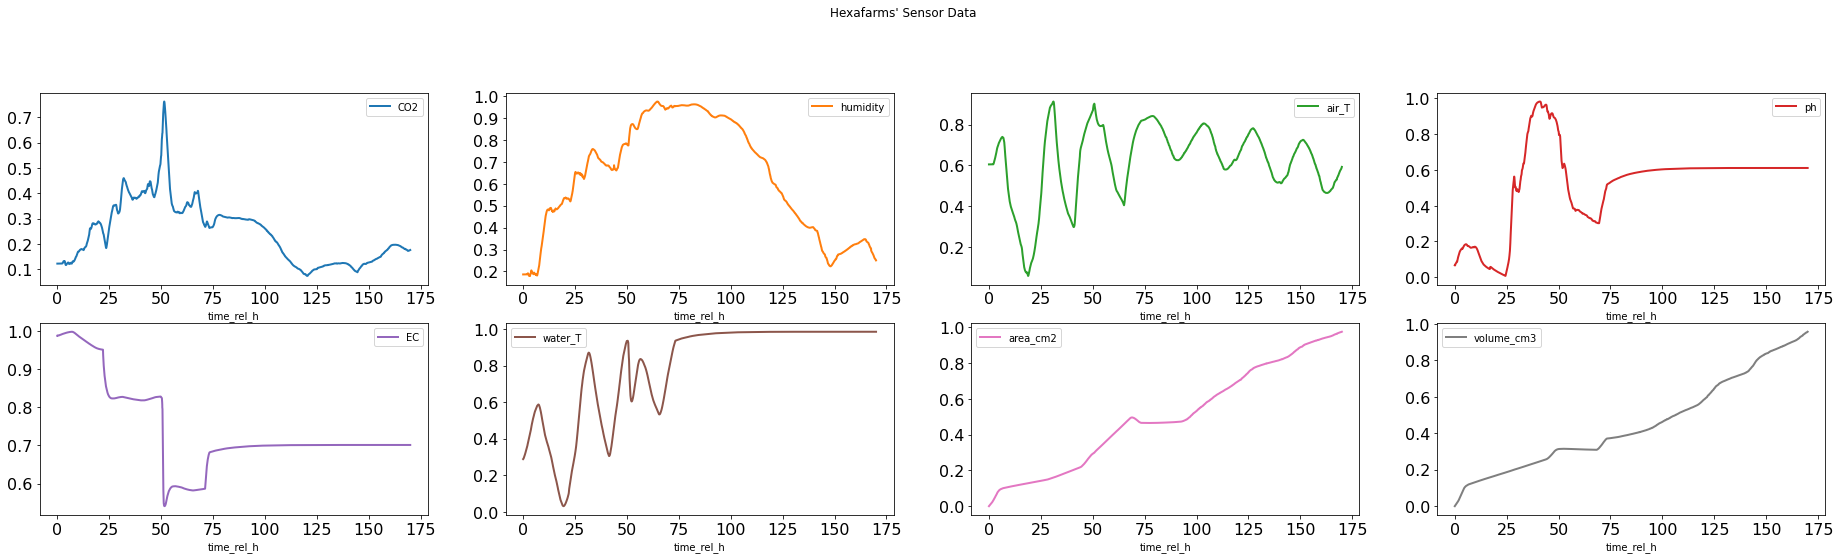

In [32]:
K = 350 # smoothing factor 
df_merge_scale_smooth = df_merge_scale.ewm(span = K).mean()
# df_merge_scale_smooth = df_merge_scale.rolling(K).median() # median smoothing
# fig, ax = plt.subplots()
# df_merge_scale_smooth.plot(figsize=(32, 6), title="Hexafarms' Sensor Data", lw=2, fontsize=16, ax=ax, grid=True)

# for line in ax.get_lines(): # if different line size is needed.
#     if line.get_label() == "area_cm2" or line.get_label() == "volume_cm3":
#         line.set_linewidth(6)
df_merge_scale_smooth.plot(figsize=(32, 12), title="Hexafarms' Sensor Data", lw=2, fontsize=16,  subplots=True, layout=(3,4), sharex=False)


In [20]:
corr_scale = df_merge_scale_smooth.corr()
mask = np.zeros_like(corr_scale, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_scale[mask] = np.nan
corr_scale.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').format(precision=2, na_rep='NA')

/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,CO2,humidity,air_T,ph,EC,water_T,area_cm2,volume_cm3
CO2,NA,NA,NA,NA,NA,NA,NA,NA
humidity,0.61,NA,NA,NA,NA,NA,NA,NA
air_T,0.19,0.20,NA,NA,NA,NA,NA,NA
ph,0.40,0.27,0.37,NA,NA,NA,NA,NA
EC,-0.37,-0.67,-0.34,-0.29,NA,NA,NA,NA
water_T,-0.03,0.22,0.72,0.49,-0.51,NA,NA,NA
area_cm2,-0.21,0.08,0.22,0.30,-0.62,0.69,NA,NA
volume_cm3,-0.21,-0.06,0.20,0.37,-0.50,0.67,0.97,NA


## Insight from visualization
- Air temperature is heavily fluctuating from the time of day and night. Need to consider insulation.
- Need to double check the robustness of growth measuring algorithm 